In [1]:
import raster_geometry as rg
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import rotate
import pickle
import sys
from skimage.transform import rescale, resize, downscale_local_mean
sys.path.insert(0,'/home/georgeos/Documents/GitHub/SYMPTOMM2')
import itertools
from joblib import Parallel, delayed
from skimage.morphology import opening
from PIL import Image       
import pymunk
from skimage.transform import PiecewiseAffineTransform, warp
from skimage import data
from copy import deepcopy
from tqdm import tqdm
import pandas as pd
from skimage import draw
import napari
from itertools import combinations
from SYMPTOMM import PSF
from matplotlib_scalebar.scalebar import ScaleBar
from cupyx.scipy.ndimage import convolve as cuconvolve
import tifffile
from skimage.exposure import match_histograms
import cupy as cp

In [2]:
def generate_curve_props(cell_timeseries):
    #Get unique cell IDs
    IDs = []
    for cell_list in cell_timeseries:
        for cell in cell_list:
            IDs.append(cell.ID)
    IDs = np.array(IDs)
    unique_IDs = np.unique(IDs)
    #For each cell, assign random curvature properties
    ID_props = []
    for ID in unique_IDs:
        freq_modif = (np.random.uniform(0.9,1.1)) # Choose one per cell
        amp_modif = (np.random.uniform(0.9,1.1)) # Choose one per cell
        phase_modif = np.random.uniform(-1,1)  # Choose one per cell
        ID_props.append([int(ID), freq_modif, amp_modif, phase_modif])
    ID_propps = np.array(ID_props)
    ID_propps[:,0] = ID_propps[:,0].astype(int)
    return np.array(ID_props)\

def gen_cell_props_for_draw(cell_timeseries_lists, ID_props):
    cell_properties = []
    for cell in cell_timeseries_lists:
        body, shape = (cell.body, cell.shape)
        vertices = []
        for v in shape.get_vertices():
            x,y = v.rotated(shape.body.angle) + shape.body.position #.rotated(self.shape.body.angle)
            vertices.append((x,y))
        vertices = np.array(vertices)

        centroid = get_centroid(vertices) 
        farthest_vertices = find_farthest_vertices(vertices)
        length = get_distance(farthest_vertices[0],farthest_vertices[1])
        width = cell.width
        #angle = np.arctan(vertices_slope(farthest_vertices[0], farthest_vertices[1]))
        angle = np.arctan2((farthest_vertices[0] - farthest_vertices[1])[1],(farthest_vertices[0] - farthest_vertices[1])[0])
        
        ID, freq_modif, amp_modif, phase_modif = ID_props[ID_props[:,0] == cell.ID][0]
        phase_mult = 20
        cell_properties.append([length, width, angle, centroid, freq_modif, amp_modif, phase_modif,phase_mult])
    return cell_properties

In [3]:
def raster_cell(length, width):
    radius = int(width/2)
    cyl_height = int(length - 2*radius)
    shape = 300 #200
    cylinder = rg.cylinder(
            shape = shape,
            height = cyl_height,
            radius = radius,
            axis=0,
            position=(0.5,0.5,0.5),
            smoothing=False)

    sphere1 = rg.sphere(shape,radius,((shape + cyl_height)/(2*shape),0.5,0.5))
    sphere2 = rg.sphere(shape,radius,((shape - cyl_height)/(2*shape),0.5,0.5))


    cell = (cylinder + sphere1 + sphere2)
    cell = cell[int(shape/2-cyl_height/2-radius-1):int(shape/2+cyl_height/2+radius+1),
                int(shape/2)-radius:int(shape/2)+radius,
               int(shape/2)-radius:int(shape/2)+radius]
    z,x,y = cell.nonzero()
    OPL_cell = np.sum(cell,axis=2)
    return OPL_cell

#OPL_cell = raster_cell(length = 55*2, width=15*2)
#plt.imshow(OPL_cell)
#plt.show()

def get_distance(vertex1, vertex2):
    return abs(np.sqrt((vertex1[0]-vertex2[0])**2 + (vertex1[1]-vertex2[1])**2))

def find_farthest_vertices(vertex_list):
    vertex_combs = list(itertools.combinations(vertex_list, 2))
    distance = 0
    farthest_vertices = 0
    for vertex_comb in vertex_combs:
        distance_ = get_distance(vertex_comb[0],vertex_comb[1])
        if distance_ > distance:
            distance = distance_
            farthest_vertices = vertex_comb
    return np.array(farthest_vertices)

def get_midpoint(vertex1, vertex2):
    x_mid = (vertex1[0]+vertex2[0])/2
    y_mid = (vertex1[1]+vertex2[1])/2
    return np.array([x_mid,y_mid])

def vertices_slope(vertex1, vertex2):
    return (vertex1[1] - vertex2[1])/(vertex1[0] - vertex2[0])

def midpoint_intercept(vertex1, vertex2):
    midpoint = get_midpoint(vertex1, vertex2)
    slope = vertices_slope(vertex1, vertex2)
    intercept = midpoint[1]-(slope*midpoint[0])
    return intercept

def get_centroid(vertices: list[tuple]) -> tuple:
    """Return the centroid of a list of vertices 
    
    Keyword arguments:
    vertices -- A list of tuples containing x,y coordinates.

    """
    return np.sum(vertices,axis=0)/len(vertices)

def place_cell(length, width, angle, position, space):
    angle = np.rad2deg(angle)
    x, y = np.array(position).astype(int)
    OPL_cell = raster_cell(length = length, width=width)
    rotated_OPL_cell = rotate(OPL_cell,angle,resize=True,clip=False,preserve_range=True)
    cell_y, cell_x = (np.array(rotated_OPL_cell.shape)/2).astype(int)
    offset_y = rotated_OPL_cell.shape[0] - space[y-cell_y:y+cell_y,x-cell_x:x+cell_x].shape[0]
    offset_x = rotated_OPL_cell.shape[1] - space[y-cell_y:y+cell_y,x-cell_x:x+cell_x].shape[1]
    space[y-cell_y+100:y+cell_y+offset_y+100,x-cell_x+100:x+cell_x+offset_x+100] += rotated_OPL_cell

In [4]:
with open("/home/georgeos/Storage/Dropbox (Cambridge University)/SYMPTOMM2_data/output_pickles/cell_timeseries_medium.p", "rb") as f:
    cell_timeseries = pickle.load(f)
with open("/home/georgeos/Storage/Dropbox (Cambridge University)/SYMPTOMM2_data/output_pickles/space.p", "rb") as f:
    space = pickle.load(f)


In [5]:
ID_props = generate_curve_props(cell_timeseries)
cell_timeseries_properties = Parallel(n_jobs=16)(delayed(gen_cell_props_for_draw)(a, ID_props) for a in cell_timeseries)

In [6]:
def transform_func(amp_modif, freq_modif, phase_modif):
    def perm_transform_func(x, amp_mult, freq_mult, phase_mult):
        return (amp_mult*amp_modif*np.cos((x/(freq_mult * freq_modif) - phase_mult * phase_modif)*np.pi)).astype(int)
    return perm_transform_func


In [7]:
do_transformation = True

def draw_scene(cell_properties):
    upscale = 1
    space_size = np.array([1000, 200]) * upscale
    space = np.zeros(space_size)
    space_masks = np.zeros(space_size)
    offsets = 50 * upscale
    for properties in cell_properties:
        length, width, angle, position, freq_modif, amp_modif, phase_modif,phase_mult = properties
        length = length*upscale; width = width * upscale; position = np.array(position) * upscale
        angle = np.rad2deg(angle) - 90
        x, y = np.array(position).astype(int) + offsets
        OPL_cell = raster_cell(length = length, width=width)
        
        if do_transformation:
            OPL_cell_2 = np.zeros((OPL_cell.shape[0],int(OPL_cell.shape[1]*2)))
            midpoint = int(np.median(range(OPL_cell_2.shape[1])))
            OPL_cell_2[:,midpoint-int(OPL_cell.shape[1]/2):midpoint-int(OPL_cell.shape[1]/2)+OPL_cell.shape[1]] = OPL_cell
            roll_coords = np.array(range(OPL_cell_2.shape[0]))
            freq_mult = (OPL_cell_2.shape[0])
            amp_mult = OPL_cell_2.shape[1]/10
            sin_transform_cell = transform_func(amp_modif, freq_modif, phase_modif)
            roll_amounts = sin_transform_cell(roll_coords,amp_mult,freq_mult,phase_mult)
            for B in roll_coords:
                OPL_cell_2[B,:] = np.roll(OPL_cell_2[B,:], roll_amounts[B])
            OPL_cell = (OPL_cell_2)
        
        rotated_OPL_cell = rotate(OPL_cell,angle,resize=True,clip=False,preserve_range=True)
        cell_y, cell_x = (np.array(rotated_OPL_cell.shape)/2).astype(int)
        offset_y = rotated_OPL_cell.shape[0] - space[y-cell_y:y+cell_y,x-cell_x:x+cell_x].shape[0]
        offset_x = rotated_OPL_cell.shape[1] - space[y-cell_y:y+cell_y,x-cell_x:x+cell_x].shape[1]
        space[
            y-cell_y:y+cell_y+offset_y  
              ,  x-cell_x  :  x+cell_x+offset_x  
             ] += rotated_OPL_cell
        space_masks[y-cell_y:y+cell_y+offset_y,x-cell_x:x+cell_x+offset_x] += (rotated_OPL_cell > 20)
        space_masks = space_masks == 1
        space_masks = opening(space_masks,np.ones((2,11)))
    return space, space_masks

In [8]:
scenes = Parallel(n_jobs=15)(delayed(draw_scene)(cell_properties) for cell_properties in tqdm(cell_timeseries_properties))

100%|██████████| 399/399 [05:48<00:00,  1.15it/s]


In [9]:
def scene_plotter(scene_array,output_dir,name,a,matplotlib_draw):
    if matplotlib_draw == True:
        plt.figure(figsize=(3,10))
        plt.imshow(scene_array)
        plt.tight_layout()
        plt.savefig(output_dir+"/{}_{}.png".format(name,str(a).zfill(3)))
        plt.clf()
        plt.close('all')
    else:
        im = Image.fromarray(scene_array.astype(np.uint8))
        im.save(output_dir+"/{}_{}.tif".format(name,str(a).zfill(3)))

In [10]:
output_dir = "/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/training_data/OPL_renders"
_ = Parallel(n_jobs=10)(delayed(scene_plotter)(scenes[x][1],output_dir,"OPL_mask",x+4000,matplotlib_draw=False) for x in range(len(scenes)))
_ = Parallel(n_jobs=10)(delayed(scene_plotter)(scenes[x][0],output_dir,"OPL_intensity",x+4000,matplotlib_draw=False) for x in range(len(scenes)))

In [11]:
##From here, prototyping phase contrast
def get_trench_segments(space):
    trench_shapes = []
    for shape, body in zip(space.shapes, space.bodies):
        if body.body_type == 2:
            trench_shapes.append(shape)
    return trench_shapes

trench_segment_props = []
for x in get_trench_segments(space):
    trench_segment_props.append([x.bb,x.area, x.a, x.b])
    
trench_segment_props = pd.DataFrame(trench_segment_props)
trench_segment_props.columns = ["bb", "area", "a", "b"]
main_segments = trench_segment_props.sort_values("area",ascending=False).iloc[0:2]

In [17]:
main_segments = main_segments.reindex(index=main_segments.index[::-1]) # run if you get a zero-width image output


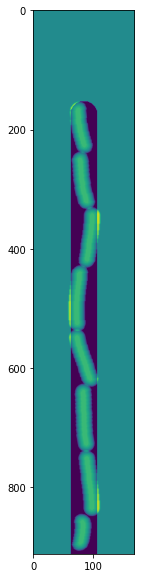

In [18]:
offset = 50

trench_multiplier = 30
cell_multiplier = 2
background_multiplier = 10
grid_def = [range(15,trench_multiplier), np.arange(0.1,cell_multiplier,0.1), range(background_multiplier)]
grid = list(itertools.product(*grid_def))
def generate_PC_OPL(trench_multiplier,cell_multiplier,background_multiplier):
    segment_1_top_left = (0 + offset, int(main_segments.iloc[0]["bb"][0] + offset))
    segment_1_bottom_right = (int(main_segments.iloc[0]["bb"][3] + offset), int(main_segments.iloc[0]["bb"][2] + offset))

    segment_2_top_left = (0 + offset, int(main_segments.iloc[1]["bb"][0] + offset))
    segment_2_bottom_right = (int(main_segments.iloc[1]["bb"][3] + offset), int(main_segments.iloc[1]["bb"][2] + offset))

    test_scene = np.zeros(scenes[300][0].shape) + background_multiplier
    rr, cc = draw.rectangle(start = segment_1_top_left, end = segment_1_bottom_right, shape = test_scene.shape)
    test_scene[rr,cc] = 1 * trench_multiplier
    rr, cc = draw.rectangle(start = segment_2_top_left, end = segment_2_bottom_right, shape = test_scene.shape)
    test_scene[rr,cc] = 1 * trench_multiplier

    circ_midpoint_y = (segment_1_top_left[1] + segment_2_bottom_right[1])/2
    radius = (segment_1_top_left[1] - offset - (segment_2_bottom_right[1] - offset))/2
    circ_midpoint_x = (offset) + radius

    rr, cc = draw.rectangle(start = segment_2_top_left, end = (circ_midpoint_x,80+segment_1_top_left[1] - offset), shape = test_scene.shape)
    test_scene[rr.astype(int),cc.astype(int)] = 1 * trench_multiplier

    rr, cc = draw.disk(center = (circ_midpoint_x, circ_midpoint_y), radius = radius, shape = test_scene.shape)
    rr_semi = rr[rr < (circ_midpoint_x + 1)]
    cc_semi = cc[rr < (circ_midpoint_x + 1)]
    test_scene[rr_semi,cc_semi] = background_multiplier
    test_scene += scenes[20][0] * cell_multiplier
    test_scene = test_scene[segment_2_top_left[0]:segment_1_bottom_right[0],segment_2_top_left[1]:segment_1_bottom_right[1]]

    expanded_scene = np.zeros((int(test_scene.shape[0]*1.2), test_scene.shape[1]*2)) + trench_multiplier
    expanded_scene[expanded_scene.shape[0] - test_scene.shape[0]:,int(test_scene.shape[1]/2):int(test_scene.shape[1]/2) + test_scene.shape[1]] = test_scene
    return expanded_scene

plt.figure(figsize=(10,10))
plt.imshow(generate_PC_OPL(30,1,10))

In [19]:
import gc
gc.collect()

157

In [20]:
PC_OPLs = np.array([generate_PC_OPL(*k) for k in grid])

In [21]:
viewer = napari.view_image(np.array(PC_OPLs), rgb=False)

In [22]:
real_phase = tifffile.imread("/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/phase_contrast_for_hist_match.tif")

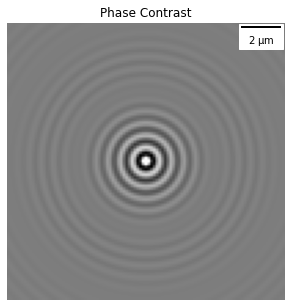

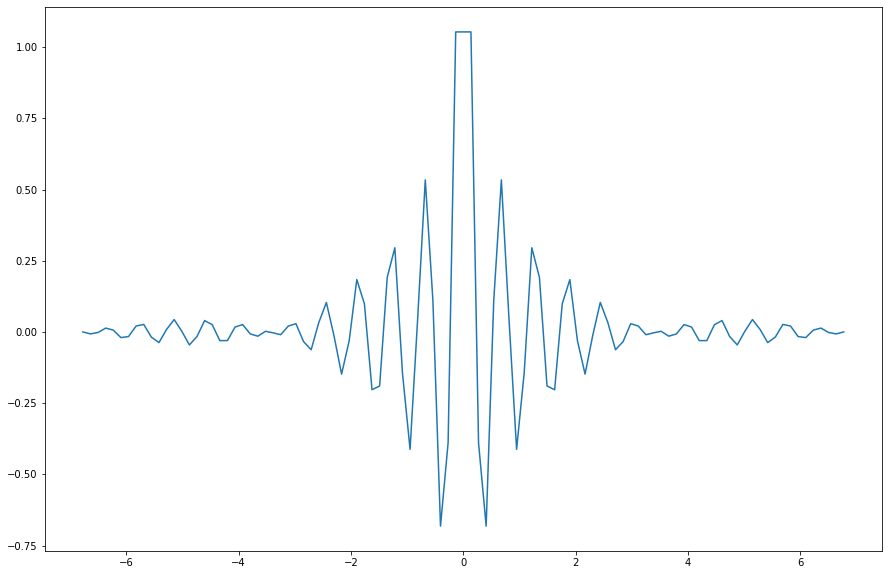

In [53]:
condensers = {
    "Ph1": (0.45, 3.75, 24),
    "Ph2": (0.8, 5.0, 24),
    "Ph3": (1.0, 9.5, 24),
    "Ph4": (1.5, 14.0, 24),
    "PhF": (1.5, 19.0, 25)
} #W, R, Diameter

from scipy.special import jv, jve


def somb(x):
    z = np.zeros(x.shape)
    x = np.abs(x)
    idx = np.nonzero(x)
    z[idx] = 2*jv(1,np.pi*x[idx])/(np.pi*x[idx])
    return z

def get_phase_contrast_kernel(R,W,radius,scale,F):
    scale1 = 1000 # micron per millimeter
    F = F * scale1 # to microm
    Lambda = 0.55 # in micron % wavelength of light
    R = R * scale1 # to microm
    W = W * scale1 # to microm
    #The corresponding point spread kernel function for the negative phase contrast 

    meshgrid_arrange = np.arange(-radius,radius + 1,1)
    [xx,yy] = np.meshgrid(meshgrid_arrange,meshgrid_arrange)
    rr = np.sqrt(xx**2 + yy**2)*scale
    rr_dl = rr*(1/F)*(1/Lambda); # scaling with F and Lambda for dimension correction
    kernel1 = np.pi*R**2*somb(2*R*rr_dl);     
    kernel2 = np.pi*(R-W)**2*somb(2*(R-W)*rr_dl)


    kernel = kernel1 - kernel2
    kernel = kernel/np.max(kernel)
    kernel[radius,radius] = kernel[radius,radius] + 1
    kernel = -kernel/np.sum(kernel)
    return kernel

W, R, diameter = condensers["Ph2"]
scale = 0.108379937 / 0.8 #0.35 #micron per pixel
kernel= get_phase_contrast_kernel(R, W, 50, scale, 5)
scalebar = ScaleBar(scale, 'um')
plt.figure(figsize=(5.1,5.1))
plt.gca().add_artist(scalebar)
plt.imshow(kernel,cmap="Greys_r")
plt.axis("off")
plt.title("Phase Contrast")
plt.show()
kernel = cp.array(kernel)
kernel_np = kernel.get()
plt.figure(figsize = (15,10))
plt.plot(np.arange(-50,51)*scale,kernel_np[50,:])
plt.show()

In [54]:
from skimage.util import random_noise
output = cuconvolve(cp.array(PC_OPLs[2696]),kernel)
output = output.get()
output = rescale(output, 1/1.75, anti_aliasing=False)[:364,:]
output = random_noise(output, mode="gaussian", mean=5,var=1,clip=False)
output_rescaled = match_histograms(output, real_phase[15][30:,:], multichannel=False)
viewer = napari.view_image(output_rescaled**2, rgb=False)

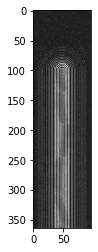

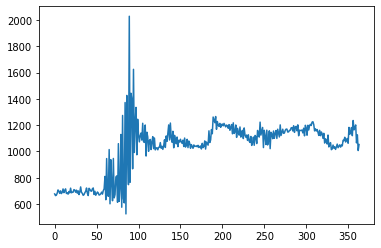

In [55]:
top_segment = output_rescaled
plt.imshow(top_segment,cmap="Greys_r")
plt.show()
plt.plot(np.mean(top_segment[:,int(top_segment.shape[1]/2) - 5:int(top_segment.shape[1]/2)+5],axis=1))

In [81]:
output.shape

(261, 49)

In [82]:
real_phase[15][30:,:].shape

(182, 48)

In [ ]:
scalebar = ScaleBar(scale*10, 'um')
plt.figure(figsize=(5,5))
plt.gca().add_artist(scalebar)
plt.imshow(real_phase[15][30:,:],cmap="Greys_r")
plt.axis("off")
plt.title("Phase Contrast")
plt.show()

In [151]:
convolved_outputs = []
for x in range(len(PC_OPLs)):
    output = cuconvolve(cp.array(PC_OPLs[x]),kernel)
    output = output.get()
    output = rescale(output, 1/1.75, anti_aliasing=False)[:364,:]
    output = random_noise(output, mode="gaussian", mean=5,var=0.85,clip=False)
    output_rescaled = match_histograms(output, real_phase[15][30:,:], multichannel=False)
    convolved_outputs.append(output_rescaled)
convolved_outputs = np.array(convolved_outputs)

In [153]:
viewer = napari.view_image(convolved_outputs**2, rgb=False)


In [ ]:
    scalebar = ScaleBar(scale, 'um')
    plt.figure(figsize=(5,5))
    plt.gca().add_artist(scalebar)
    plt.imshow(output_rescaled,cmap="Greys_r")
    plt.axis("off")
    plt.title("Phase Contrast")
    plt.show()

364

In [103]:
output.shape

(182, 97)

In [104]:
cuconvolve(cp.array(PC_OPLs[x]),kernel).shape

(912, 170)